# Zillow Clustering Project
***

### Executive Summary

__Project Goal__

* Discover drivers of error in the Zestimate.

__Overall Findings__

* According to the important features property of my best model, the top drivers of logerror are structure value per square foot, size, and location.
* Unfortunately, since my model did not perform much better than baseline, I recommend further exploration using the features listed above as a starting point for clustering.
***

### My Process

*  Write a README.md file that details my process, my findings, and instructions on how to recreate my project.
* Acquire the zillow data from the Codeup Database
* Clean and prepare the zillow data:
    * Select only the useful columns
    * Remove or impute null values
    * Rename columns as necessary
    * Change data types as necessary
    * Create county and state columns
    * Remove entries that don't make sense or are illegal
    * Remove outliers
* Plot individual variable distributions
* Determine at least two initial hypotheses, run the statistical tests needed, evaluate the outcome, and record results.
* Create at least three different cluster groups and perform statistical analysis to determine their usefulness.
* Create dummy variables for the categorical features in my data sets
* Split the data sets into X and y groups
* Scale the X groups before use in the model
* Set baseline using logerror mean
* Create and evaluate models on train and validate sets
* Choose best model and evaluate it on test data set
* Document conclusions, takeaways, and next steps

***

### Necessary Imports
***

In [1]:
import numpy as np
import pandas as pd

#For visualizations
import matplotlib.pyplot as plt
import seaborn as sns

#For stats
import scipy.stats as stats

#Custom modules
import env
import wrangle
import explore
import model

import warnings
warnings.filterwarnings('ignore')

***

## Acquire Data

__Data Dictionary__

| Target | Datatype | Definition |
|:-------|:---------|:------------|
| logerror | float | The Zestimate error |

| Feature | Datatype | Definition |
|:--------|:---------|:------------|
| bathroom_count | float | The number of bathrooms in the property (Includes values for half baths and other combinations) |
| quality_type | float | The quality rating of the property (1 - 10) |
| home_square_feet | float | The area of the property in square feet |
| latitude | float | The latitude of the property |
| longitude | float | The longitude of the property |
| room_count | float | The number of rooms the property has |
| county | str | The name of the county the property resides in |
| age | float | The age of the property in years |
| acres | float | The number of acres the property sits on |
| tax_rate | float | The tax rate of the property |
| structure_dollar_per_sqft | float | The value of the structure per square foot |
| land_dollar_per_sqft | float | The value of the land per square foot |
| bath_bed_ratio | float | The ratio of bathrooms to bedrooms of the property |

__Retrieve the Zillow Data From the Codeup Database__

In [2]:
zillow = wrangle.wrangle_zillow()

__Get a Brief Overview of the Data__

In [3]:
zillow.head()

,bathroom_count,quality_type,home_square_feet,latitude,longitude,room_count,logerror,county,age,acres,tax_rate,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio
0,3.5,6.0,3100.0,33634931.0,-117869207.0,0.0,0.025595,Orange,19.0,0.103444,0.010763,156.681613,119.300710,0.875000
1,1.0,6.0,1465.0,34449266.0,-119281531.0,5.0,0.055619,Ventura,50.0,0.290335,0.012225,60.068259,29.730371,0.500000
2,2.0,6.0,1243.0,33886168.0,-117823170.0,6.0,0.005383,Orange,55.0,0.193572,0.011488,68.615447,56.865394,0.666667
3,3.0,8.0,2376.0,34245180.0,-118240722.0,0.0,-0.103410,Los Angeles,47.0,0.299311,0.012247,45.840909,2.778417,0.750000
4,3.0,8.0,1312.0,34185120.0,-118414640.0,0.0,0.006940,Los Angeles,53.0,6.395340,0.012846,56.159299,0.164139,1.000000


In [4]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67783 entries, 0 to 77380
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   bathroom_count             67783 non-null  float64
 1   quality_type               67783 non-null  float64
 2   home_square_feet           67783 non-null  float64
 3   latitude                   67783 non-null  float64
 4   longitude                  67783 non-null  float64
 5   room_count                 67783 non-null  float64
 6   logerror                   67783 non-null  float64
 7   county                     67783 non-null  object 
 8   age                        67783 non-null  float64
 9   acres                      67783 non-null  float64
 10  tax_rate                   67783 non-null  float64
 11  structure_dollar_per_sqft  67783 non-null  float64
 12  land_dollar_per_sqft       67783 non-null  float64
 13  bath_bed_ratio             67783 non-null  flo

In [5]:
zillow.describe()

,bathroom_count,quality_type,home_square_feet,latitude,longitude,room_count,logerror,age,acres,tax_rate,structure_dollar_per_sqft,land_dollar_per_sqft,bath_bed_ratio
count,67783.000000,67783.000000,67783.000000,6.778300e+04,6.778300e+04,67783.000000,67783.000000,67783.000000,67783.000000,67783.000000,67783.000000,67783.000000,67783.000000
mean,2.204026,6.314445,1676.031099,3.400450e+07,-1.181920e+08,1.602467,0.016492,48.153652,0.638676,0.013114,95.809714,36.744790,0.775814
std,0.840533,1.316780,763.629573,2.690511e+05,3.618249e+05,2.908051,0.164251,22.779800,2.765654,0.004941,52.210349,47.620976,0.285932
min,1.000000,1.000000,242.000000,3.333953e+07,-1.194753e+08,0.000000,-4.655420,1.000000,0.005418,0.000094,0.039833,0.003023,0.200000
25%,2.000000,6.000000,1156.000000,3.380550e+07,-1.184068e+08,0.000000,-0.023673,31.000000,0.137741,0.011640,61.841927,5.993511,0.600000
50%,2.000000,6.000000,1488.000000,3.401086e+07,-1.181599e+08,0.000000,0.006278,47.000000,0.167883,0.012275,90.056883,24.010707,0.666667
75%,3.000000,7.000000,1996.000000,3.417700e+07,-1.179135e+08,0.000000,0.037353,63.000000,0.239073,0.013416,121.314490,49.079012,1.000000
max,10.000000,12.000000,7970.000000,3.481877e+07,-1.175723e+08,14.000000,3.394544,139.000000,160.032369,0.493647,1243.317708,1398.850575,7.500000


__Key Takeaways:__
    
* 67,783 entries
* 14 columns
* Data contains only properties that are considered to be single unit and had a transaction in the year 2017. For properties with more than one transaction for the year, only the latest transaction information was used.
* Dropped columns that were missing more than 50% of entries
* Dropped rows that were missing more than 70% of values
* Removed entries with 0 bedrooms and 0 bathrooms
* Removed entries that were over 8,000 sqft
* Removed entries that did not have at least 120 sqft per bedroom
* Removed homes that were valued at over 5,000,000
* Removed homes that were taxed over 20,000
* Dropped all other unnecessary columns
* Dropped columns that were related to the features above

***
__Individual Variable Distributions__

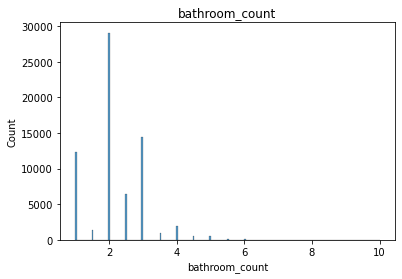

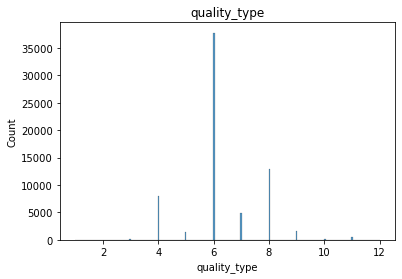

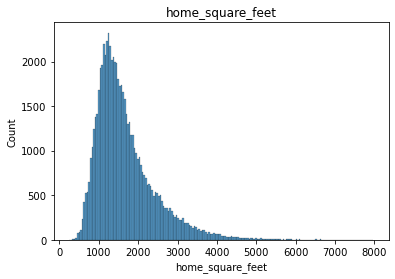

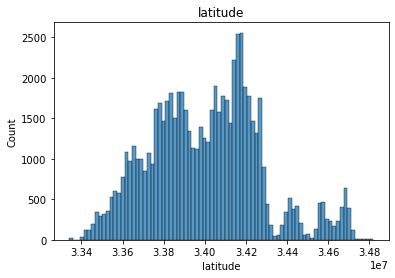

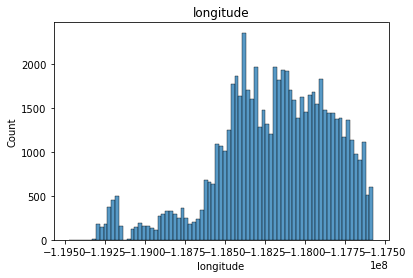

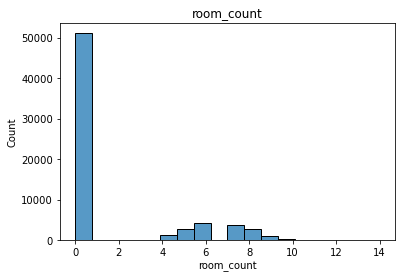

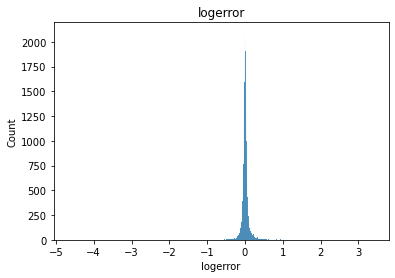

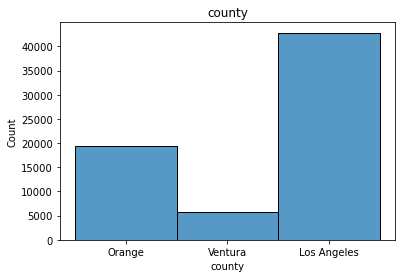

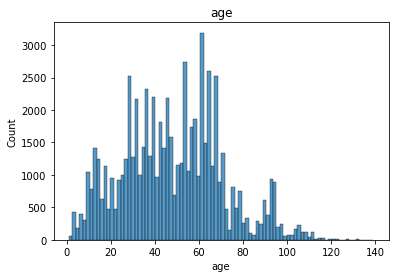

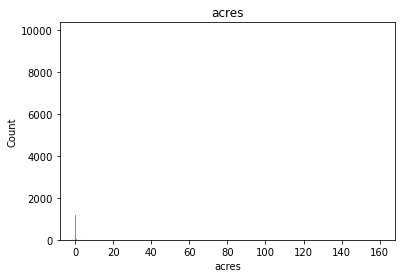

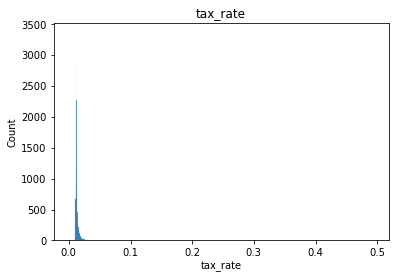

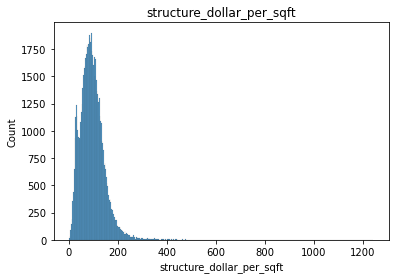

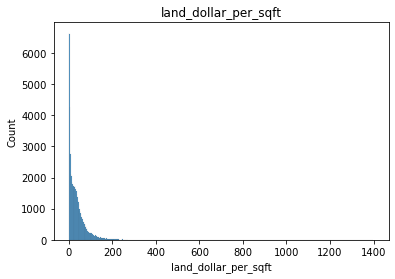

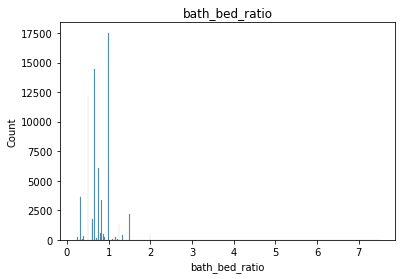

In [6]:
wrangle.get_dists(zillow)


__Split Data Into Train, Validate, and Test Data Sets__

In [7]:
train, validate, test = wrangle.train_validate_test_split(zillow)
train.shape, validate.shape, test.shape

((37958, 14), (16268, 14), (13557, 14))

***

## Explore

__Compare logerror to Each Numeric Variable__

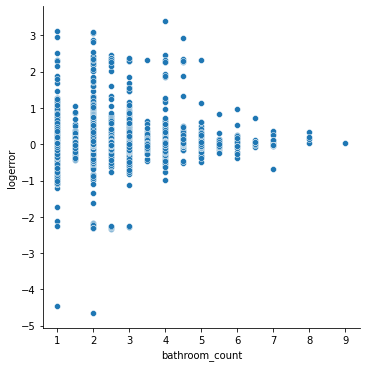

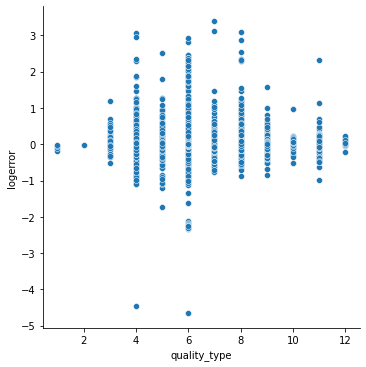

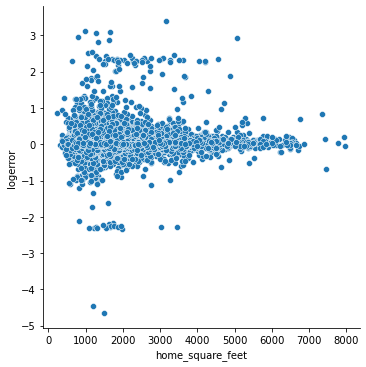

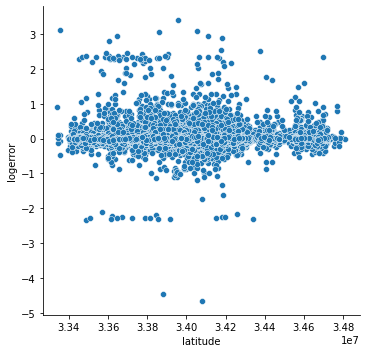

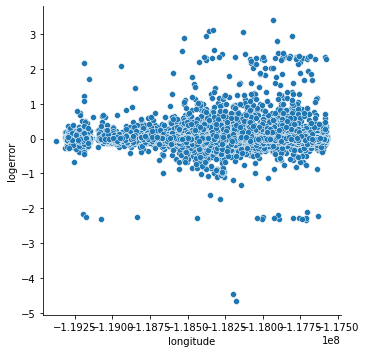

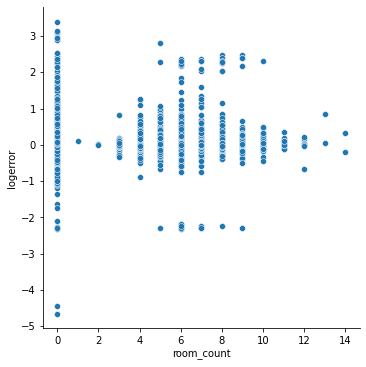

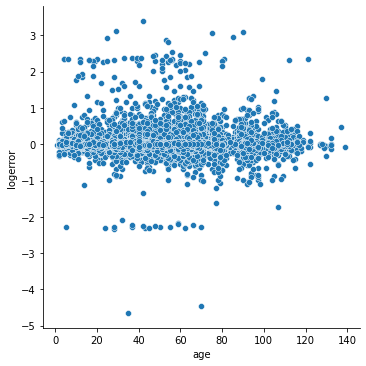

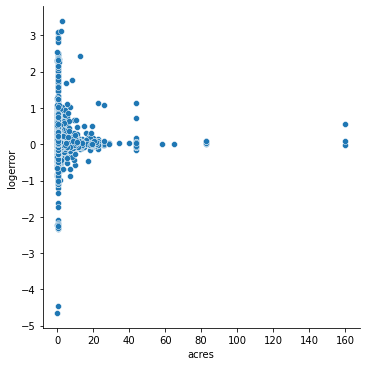

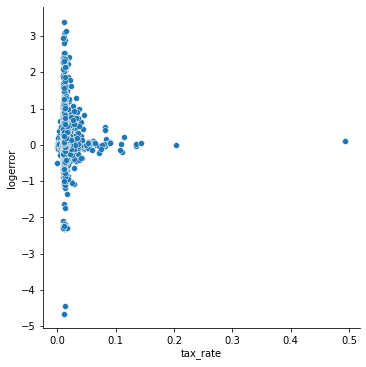

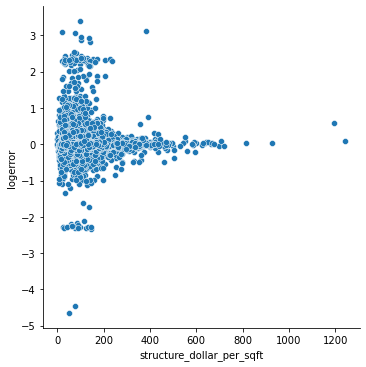

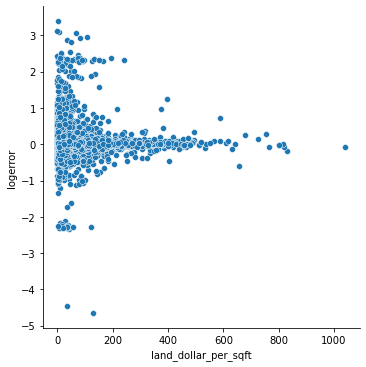

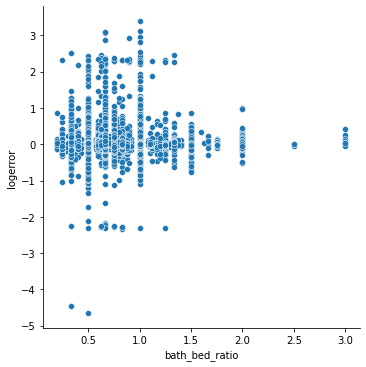

In [8]:
explore.get_logerror_plots(train)

Key Takeaways:

* logerror decreases as bathroom_count increases
* Greatest logerror exists for average homes. Quality types 4 through 8
* As home size increases, logerror decreases. There are two groups among houses that are smaller (< 4000 sqft). One group has higher logerror than the average, while the other has lower logerror than the average. What sets these smaller homes apart from the others?
* Same grouping seen in smaller latitude values.
* Same grouping seen in larger longitude values.
* Greatest range of logerror exists for properties with room_count = 0.
* Age has a similar plot to the latitude plot. Perhaps age, latitude, and longitude would make good features for clustering.
* Smaller plots of land have the greatest logerror
* Those with lower tax rates (< .5) have a much greater range of logerror than others.
* Properties with a lower structure_dollar_per_sqft (< 300) have a much higher positive logerror.
* Properties with a lower land_dollar_per_sqft (<200) have a much higher positive logerror. Perhaps these last two features would be good candidates for clustering.
* There is a greater range of logerror for properties with bath_bed_ratio less than about 1.5.

__Now Include County__

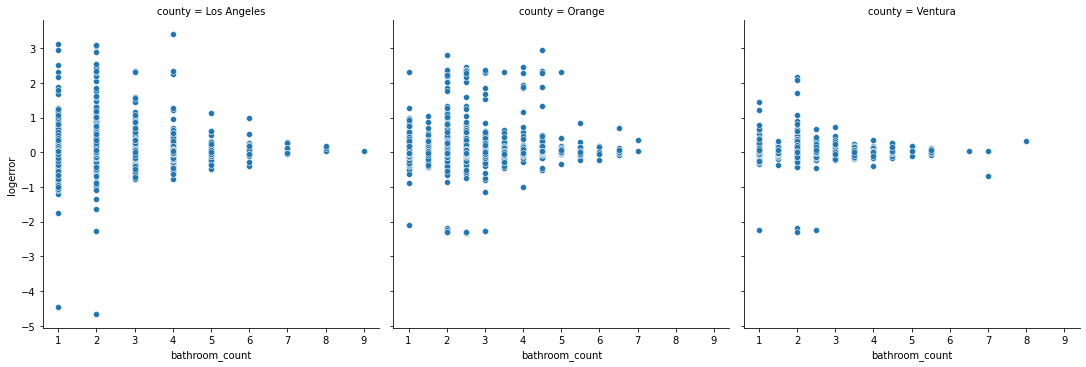

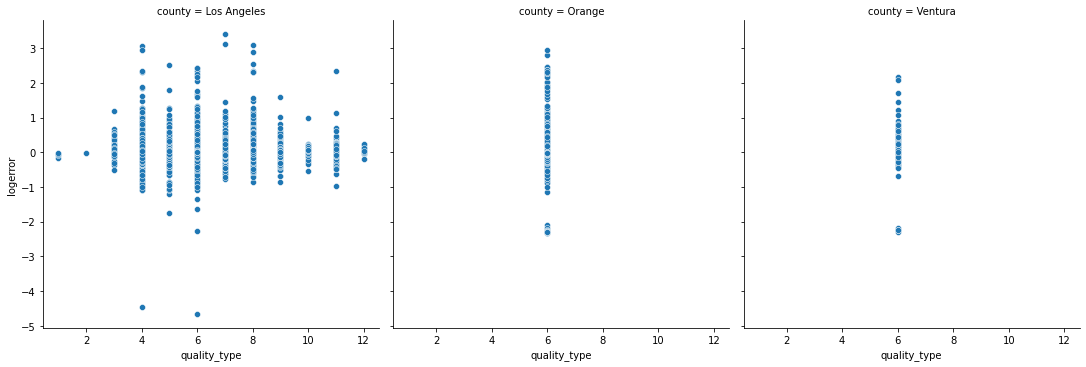

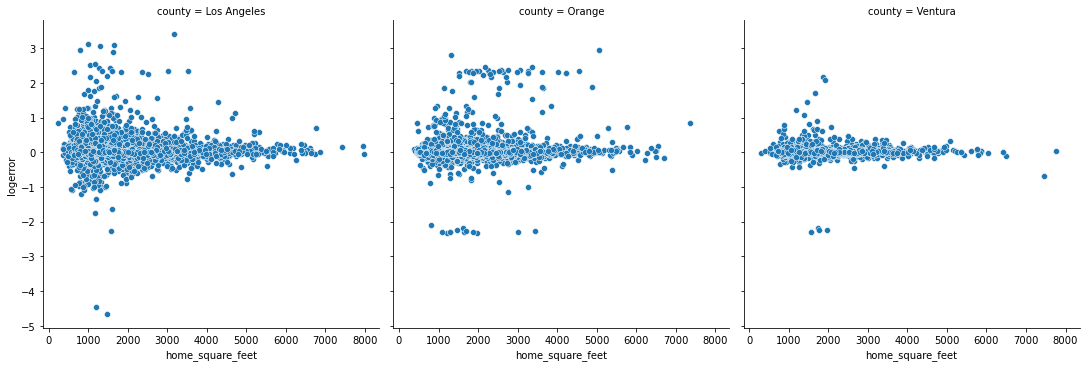

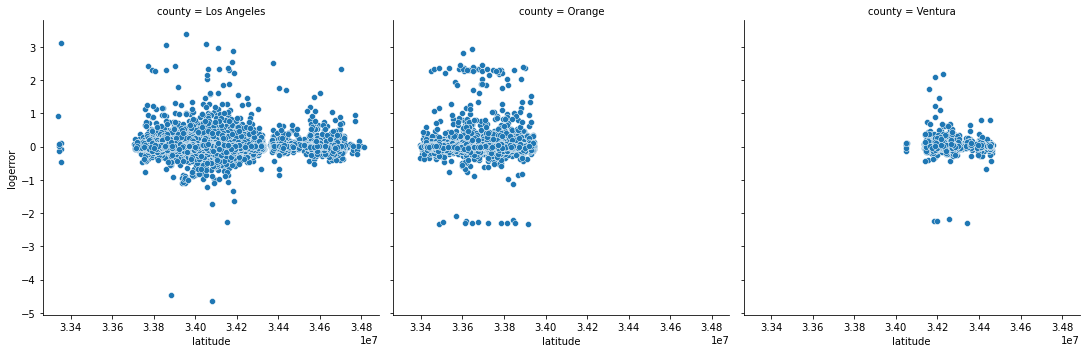

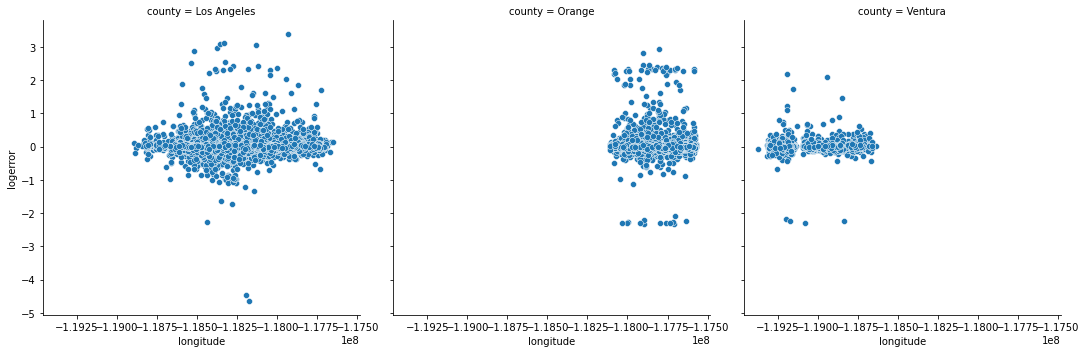

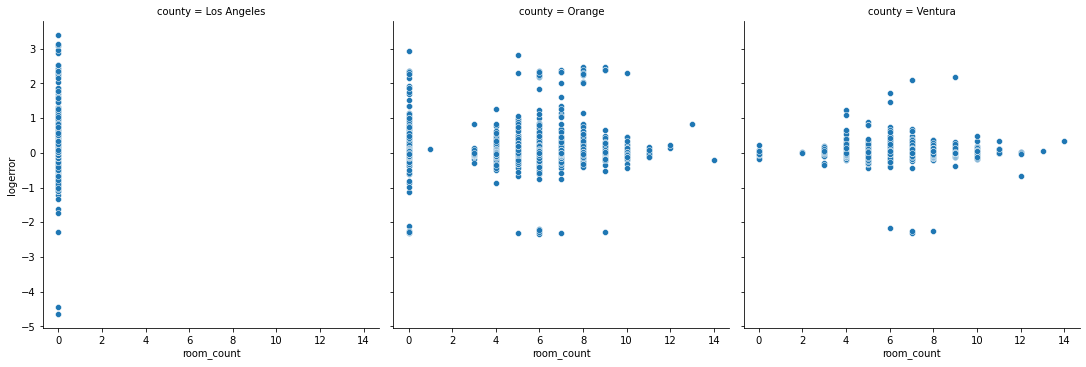

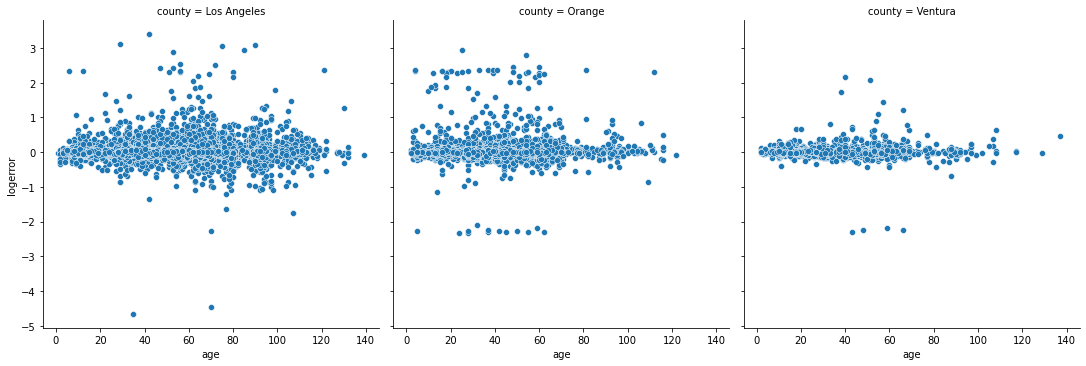

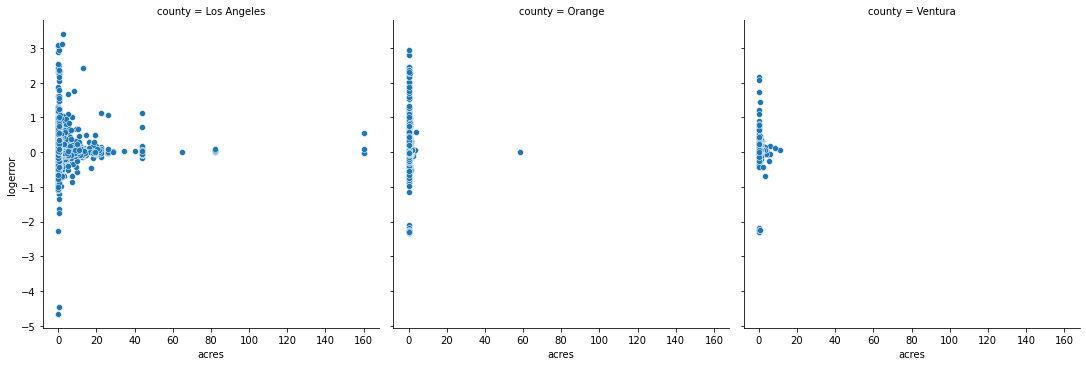

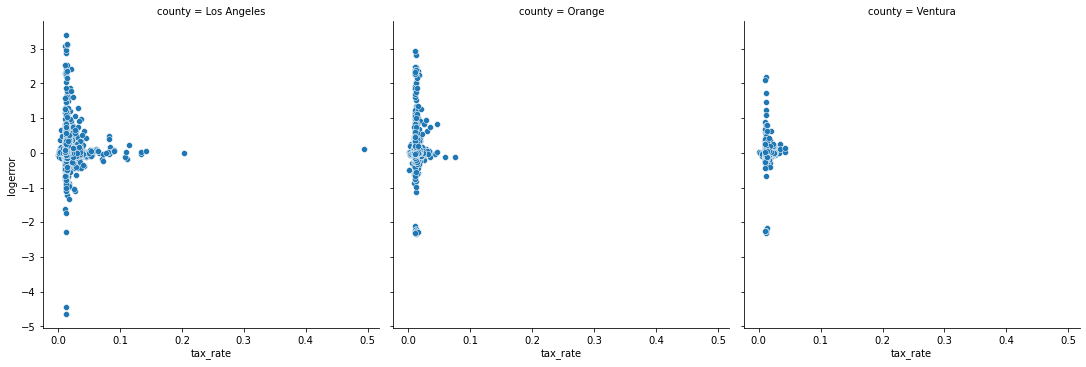

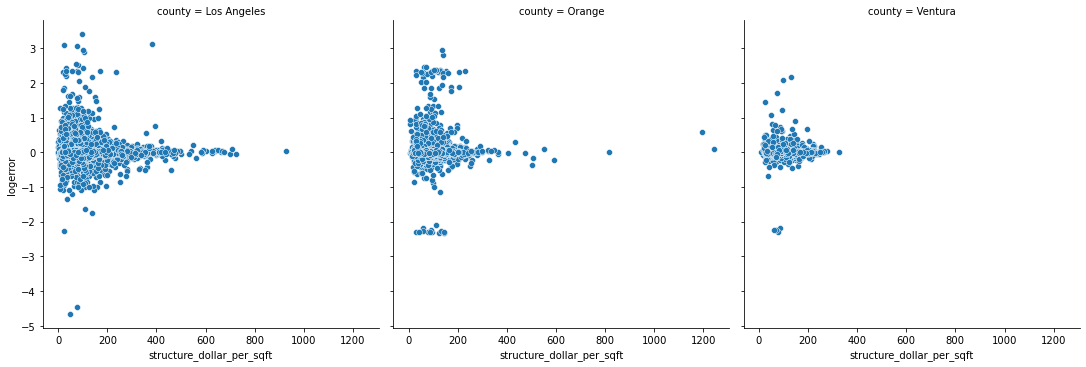

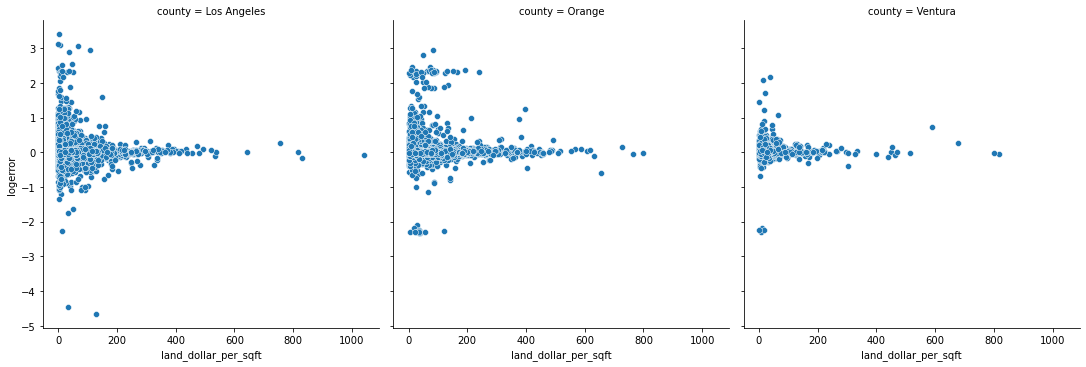

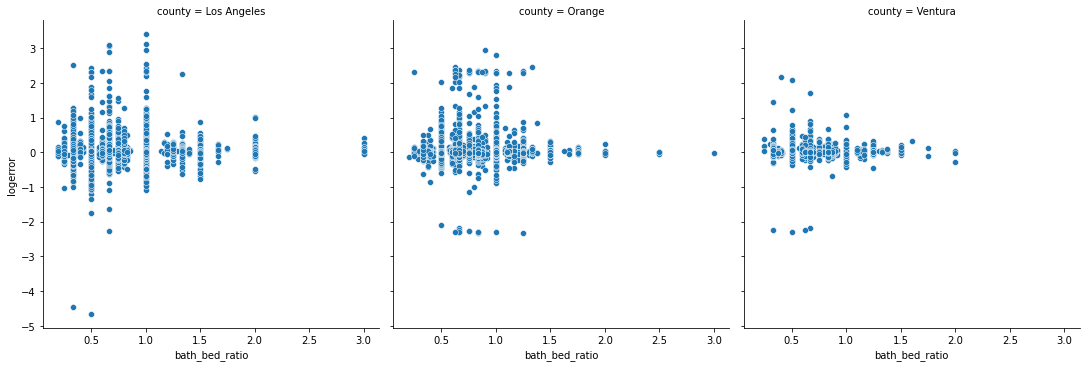

In [9]:
explore.get_logerror_plots(train, col_var = 'county')

__Key Takeaways:__
    
* Orange and Ventura counties have only the quality_type of 6 with a wide range of logerror.
* Those two distinct groups mentioned before are most prevalent in Orange county properties.
* Each county has the same trend as before, decreasing logerror with increasing property size.
* The cheaper, lower quality homes in LA county are between 3.38 and 3.41 latitude and around -1.1825x10^8 longitude.
* LA County only has room_count = 0. Orange and Ventura counties have many more rooms, but Orange county properties that have 0 rooms have a wide range of logerror.
* Properties in Orange and Ventura county appear to have smaller acres than properties in LA county. 
* LA County seems to have higher property tax rates than Orange and Ventura Counties.

***

## Statistical Analysis


__Hypothesis 1__

$H_0$: home_square_feet is not linearly correlated with logerror.
    
$H_a$: home_square_feet is linearly correlated with logerror.
    
alpha = 0.05

In [10]:
corr, p = stats.pearsonr(train.home_square_feet, train.logerror)
corr, p

(0.04774783861034919, 1.3072349673671478e-20)

Since p-value is less than 0.05, we reject the null hypothesis. Home_square_feet is linearly correlated with logerror, but the correlation is extremely weak with a correlation coefficient of about 0.05. This may not be useful.

__Hypothesis 2__

$H_0$: The average logerror for properties in Los Angeles county <= The average logerror for properties in Ventura county.

$H_a$: The average logerror for properties in Los Angeles county > The average logerror for properties in Ventura county.

alpha = 0.05

In [11]:
t, p = stats.ttest_ind(train[train.county == 'Los Angeles'].logerror, train[train.county == 'Ventura'].logerror, equal_var = False)
t, p

(-0.10770420189840343, 0.9142354373527628)

Since p-value is greater than 0.05, we fail to reject the null hypothesis. The average logerror for properties in Los Angeles county is not significantly greater than the average logerror for properties in Ventura county.

__Hypothesis 3__

$H_0$: The average logerror for properties in Los Angeles county >= The average logerror for properties in Orange county.
    
$H_a$: The average logerror for properties in Los Angeles county < The average logerror for properties in Orange county.
    
alpha = 0.05

In [12]:
t, p = stats.ttest_ind(train[train.county == 'Los Angeles'].logerror, train[train.county == 'Orange'].logerror, equal_var = False)
t, p

(-2.761686055670494, 0.005756283437029695)

Since the p-value is less than 0.05 and the test statistic is negative, we reject the null hypothesis. The average logerror for properties in Los Angeles county is significantly less than the average logerror for properties in Orange county.

__Key Takeaways:__

* home_square_feet is linearly correlated with logerror, but only weakly.
* The average logerror for properties in Los Angeles county is not significantly greater than the average logerror for properties in Ventura county.
* The average logerror for properties in Los Angeles county is significantly less than the average logerror for properties in Orange county.

***

## Clustering

For this stage of exploration, I would like to create clusters using three different groups of features:
* Group 1: age, latitude, longitude
* Group 2: home_square_feet, acres, bath_bed_ratio
* Group 3: structure_dollar_per_sqft, land_dollar_per_sqft

For each group of clusters, I chose k using the elbow method. To see the inertia graphs, please take a look at my separate explore file.

__Cluster Creation__

In [13]:
#Create the list of dictionaries for the cluster groups
clusters = [
    {
        'name':'age_location_cluster',
        'k': 6,
        'features': ['age', 'latitude', 'longitude']
    },
    {
        'name':'size_cluster',
        'k': 5,
        'features': ['home_square_feet', 'bath_bed_ratio', 'acres']
    },
    {
        'name':'value_cluster',
        'k': 5,
        'features': ['structure_dollar_per_sqft', 'land_dollar_per_sqft']
    }]

In [14]:
train, validate, test = explore.get_clusters(train, validate, test, clusters)

__Is the Age and Location Cluster Useful?__

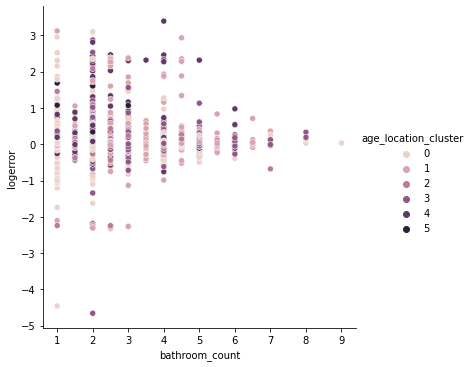

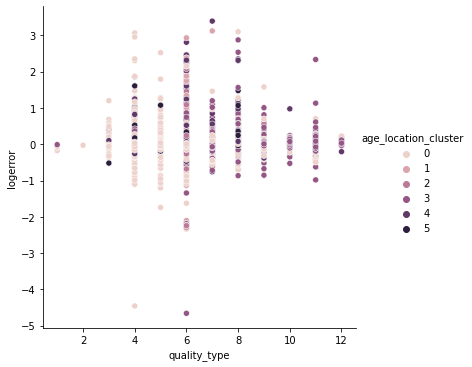

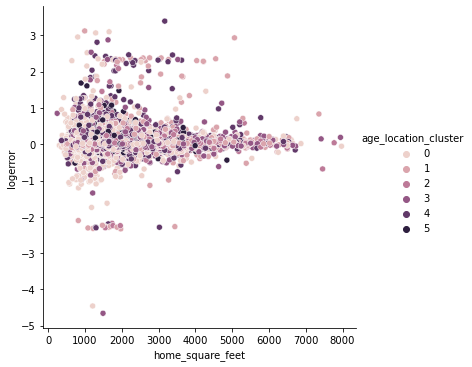

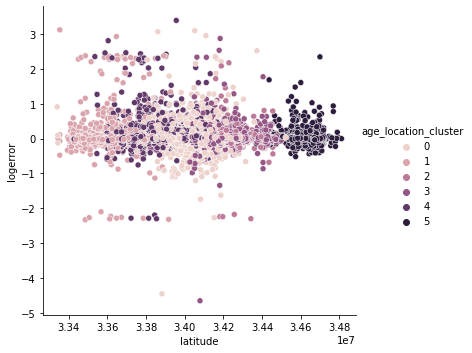

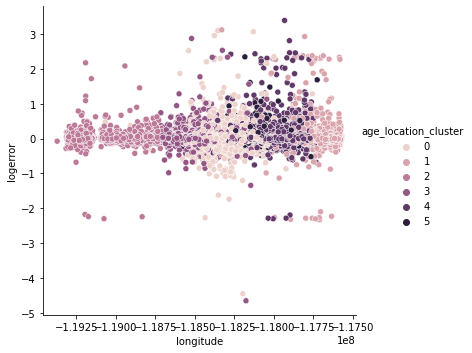

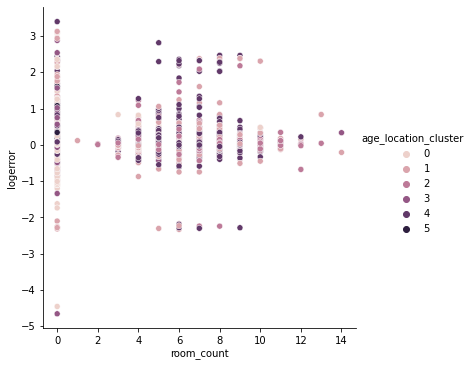

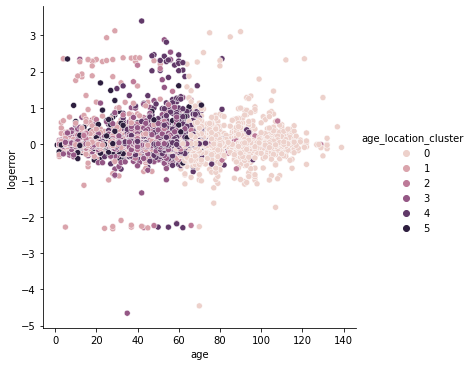

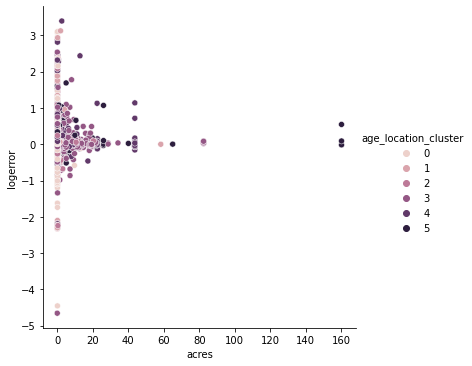

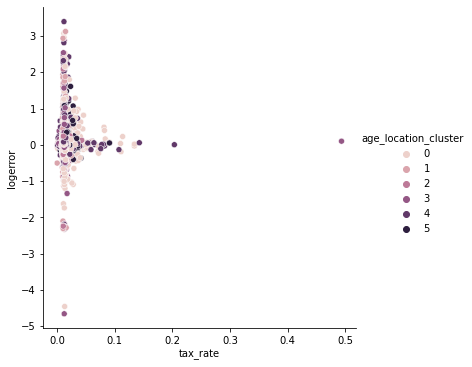

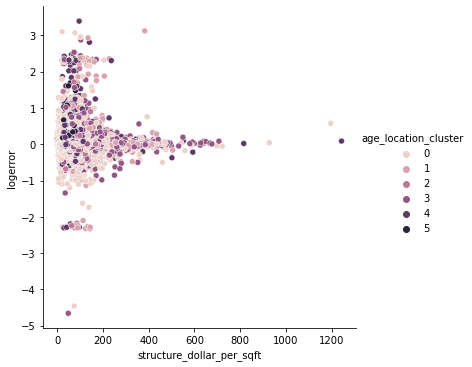

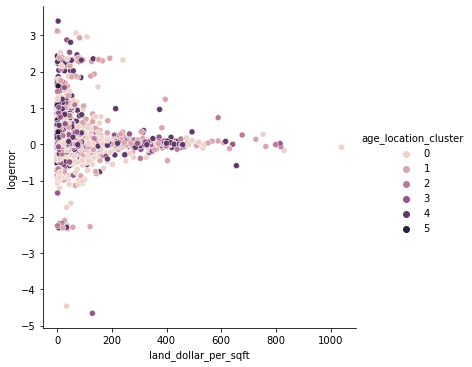

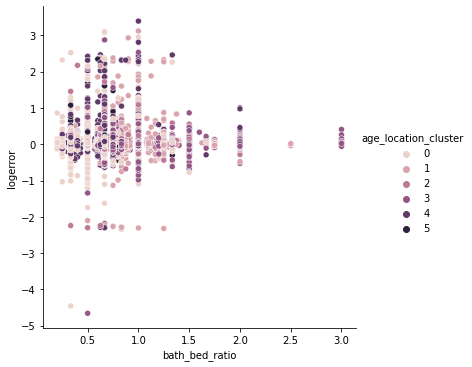

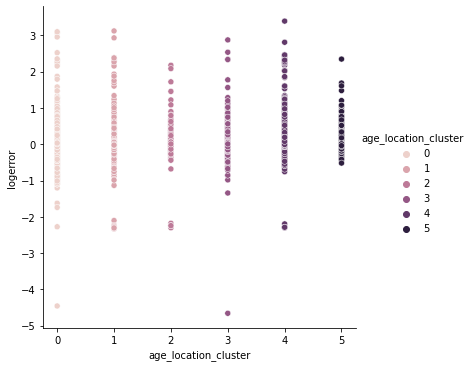

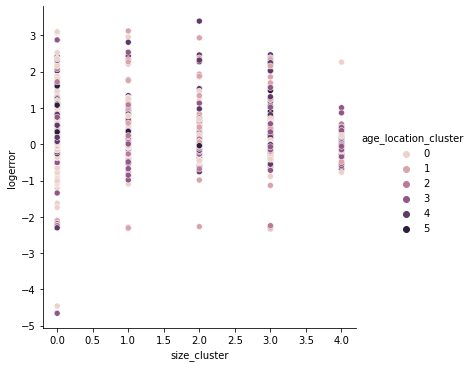

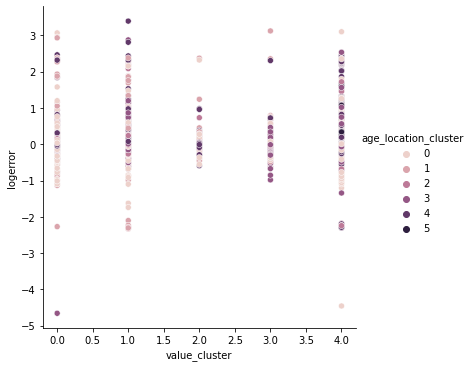

In [15]:
explore.get_logerror_plots(train, hue_var = 'age_location_cluster')

__Statistical Analysis For Group 1__

__Hypothesis 1__

$H_0$: The average logerror for properties in age_location cluster group 5 == The average logerror for properties in age_location cluster group 0.

$H_a$: The average logerror for properties in age_location cluster group 5 != The average logerror for properties in age_location cluster group 0.

alpha = 0.05

In [16]:
t, p = stats.ttest_ind(train[train.age_location_cluster == 5].logerror, train[train.age_location_cluster == 0].logerror, equal_var = False)
t, p

(2.2971245970447667, 0.021662313726238565)

Since p-value is less than 0.05, we reject the null hypothesis. Average logerror for properties in age_location_cluster group 5 is significantly different than the average logerror for age_location_cluster group 0.

__Hypothesis 2__

$H_0$: The average logerror for properties in age_location cluster group 0 == The average logerror for properties in age_location cluster group 4.

$H_a$: The average logerror for properties in age_location cluster group 0 != The average logerror for properties in age_location cluster group 4.

alpha = 0.05

In [17]:
t, p = stats.ttest_ind(train[train.age_location_cluster == 0].logerror, train[train.age_location_cluster == 4].logerror, equal_var = False)
t, p

(-5.150065655145754, 2.637726905575167e-07)

Since the p-value is less than 0.05, we reject the null hypothesis. Average logerror for properties in age_location_cluster group 0 is significantly different than the average logerror for properties in age_location_cluster 4.

__The age_location_cluster Group Appears Useful__
***

__Is the Size Cluster Group Useful?__

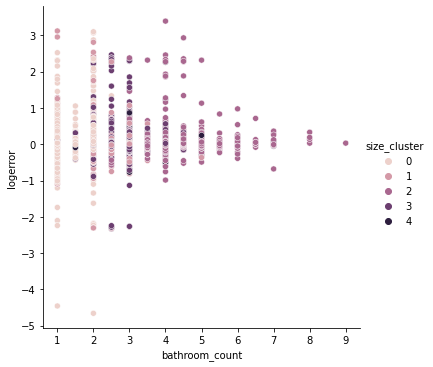

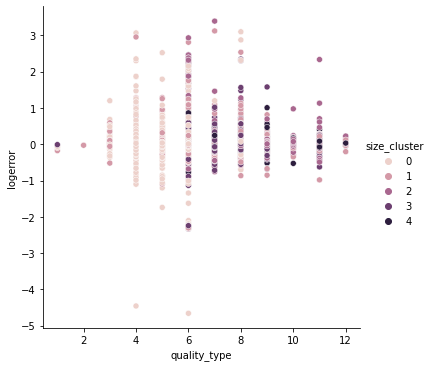

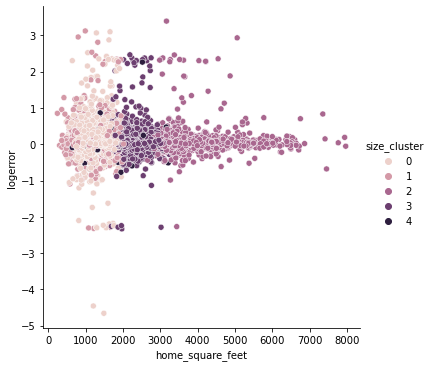

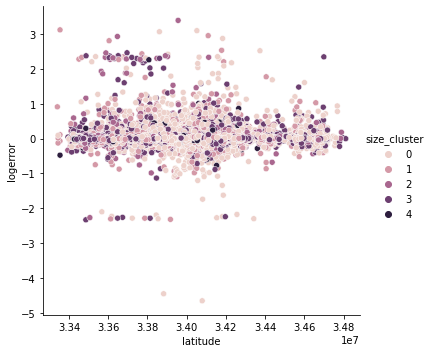

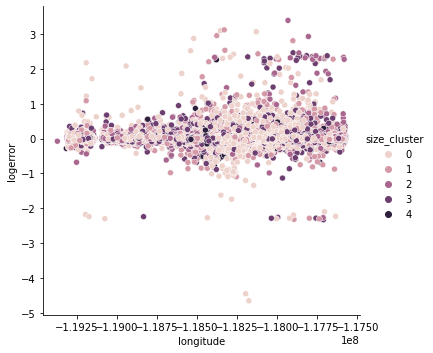

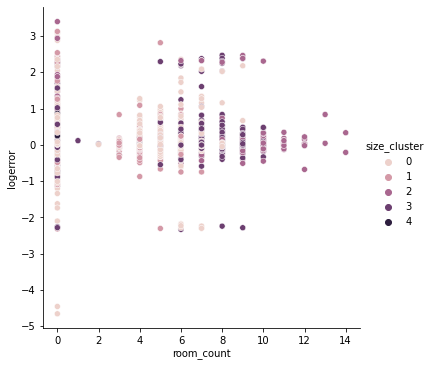

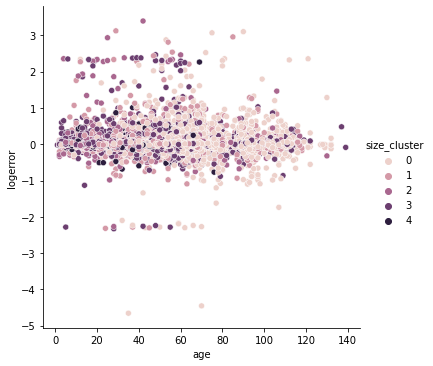

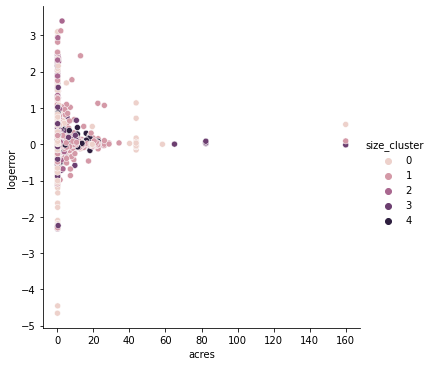

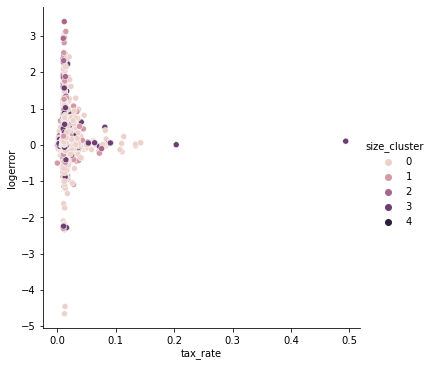

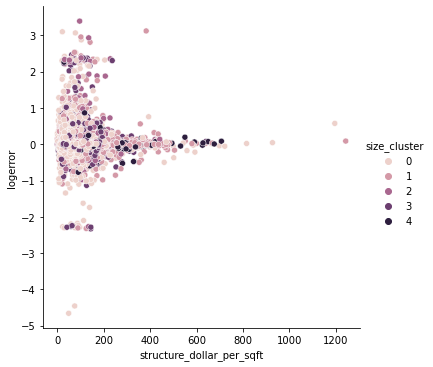

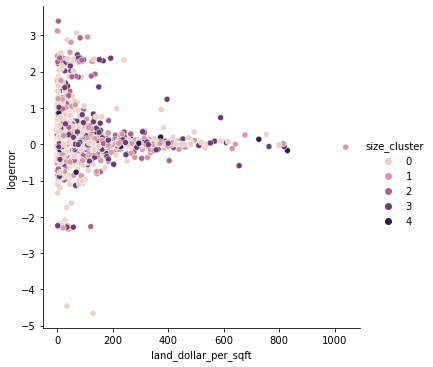

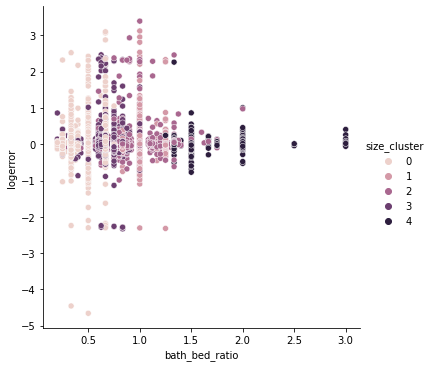

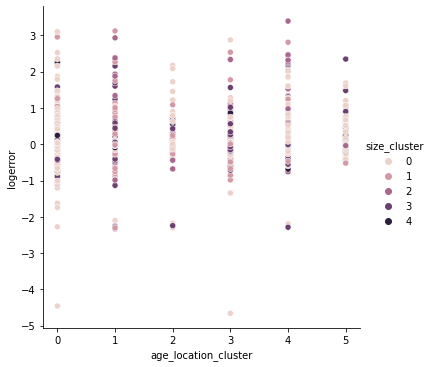

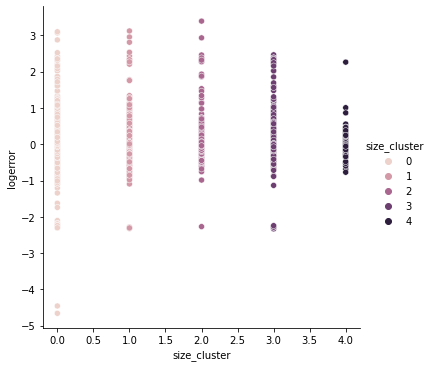

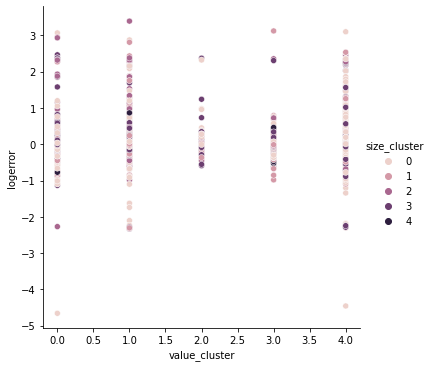

In [18]:
explore.get_logerror_plots(train, hue_var = 'size_cluster')

__Statistical Analysis For Group 2__

__Hypothesis 1__

$H_0$: Average logerror for properties in size_cluster 1 == Average logerror for properties in size_cluster 3.

$H_a$: Average logerror for properties in size_cluster 1 != Average logerror for properties in size_cluster 3.

alpha = 0.05

In [19]:
t, p = stats.ttest_ind(train[train.size_cluster == 1].logerror, train[train.size_cluster == 3].logerror, equal_var = False)
t, p

(-4.321985709313276, 1.5547817376261316e-05)

Since p-value is less than 0.05, we reject the null hypothesis. Average logerror for properties in size_cluster group 1 is significantly different than the average logerror for properties in size_cluster group 3.

__Hypothesis 2__

$H_0$: Average logerror for properties in size_cluster 2 == Average logerror for properties in size_cluster 3.

$H_a$: Average logerror for properties in size_cluster 2 != Average logerror for properties in size_cluster 3.

alpha = 0.05

In [20]:
t, p = stats.ttest_ind(train[train.size_cluster == 2].logerror, train[train.size_cluster == 3].logerror, equal_var = False)
t, p

(4.261374422613401, 2.0903287083439828e-05)

Since p-value is less than 0.05, we reject the null hypothesis. Average logerror for properties in size_cluster 2 is significantly different than the average logerror for properties in size_cluster 3.

__The size_cluster Group Appears Useful__
***

__Is the Value Cluster Group Useful?__

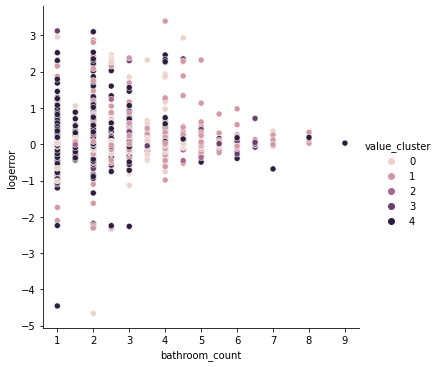

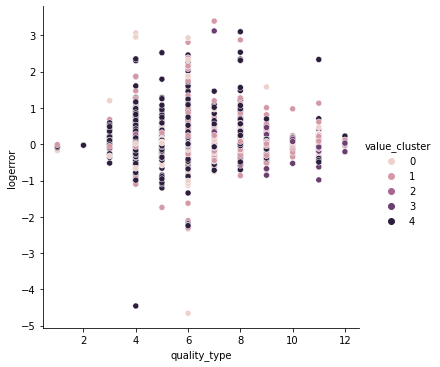

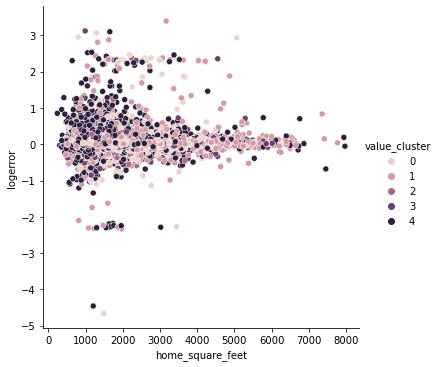

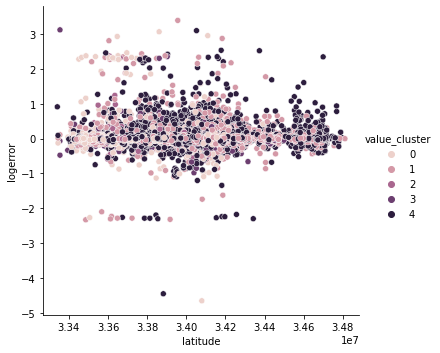

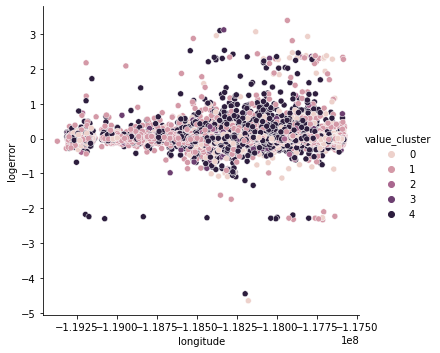

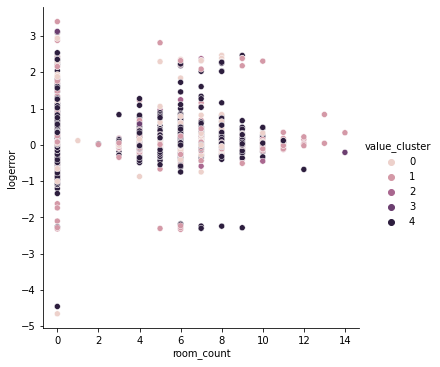

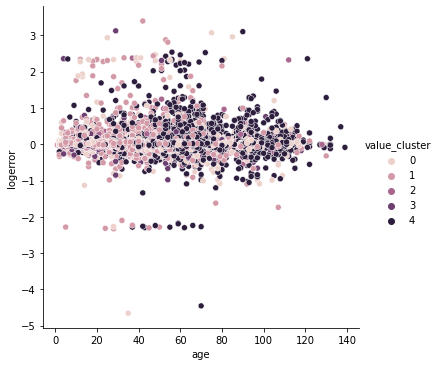

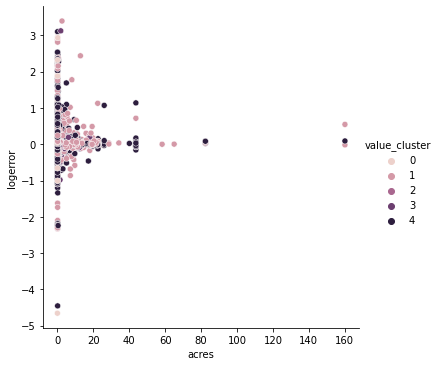

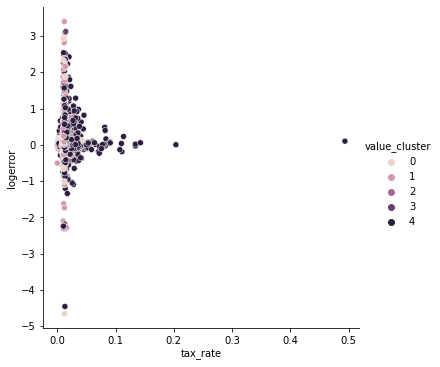

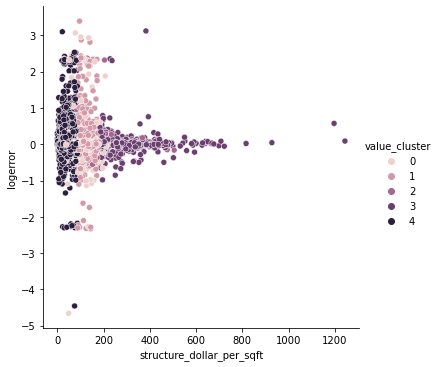

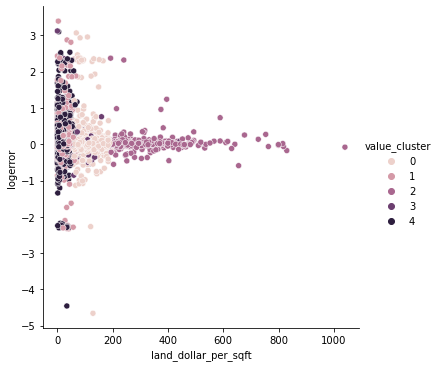

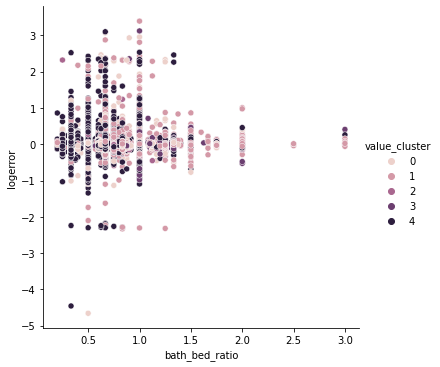

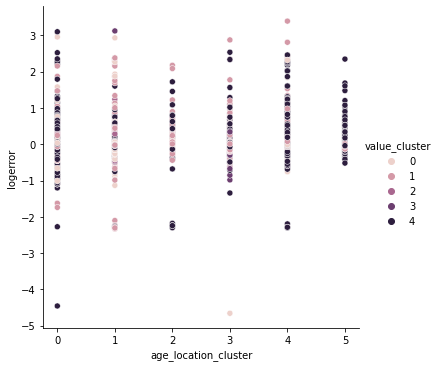

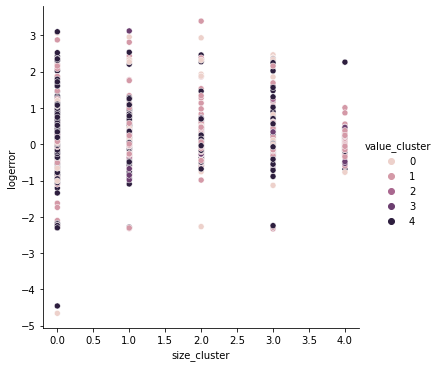

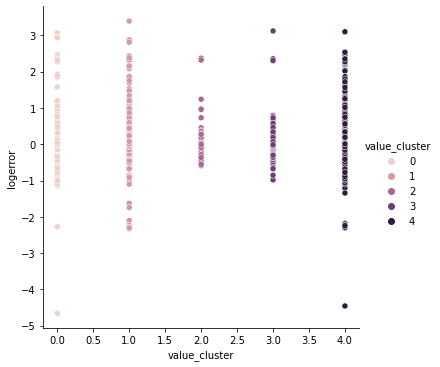

In [21]:
explore.get_logerror_plots(train, hue_var = 'value_cluster')

__Statistical Analysis For Group 3__

__Hypothesis 1__

$H_0$: Average logerror for properties in value_cluster 0 == Average logerror for properties in value_cluster 4.

$H_a$: Average logerror for properties in value_cluster 0 != Average logerror for properties in value_cluster 4.

alpha = 0.05

In [22]:
t, p = stats.ttest_ind(train[train.value_cluster == 0].logerror, train[train.value_cluster == 4].logerror, equal_var = False)
t, p

(-2.064416097398358, 0.03900290750092411)

Since p-value is less than 0.05, we reject the null hypothesis. Average logerror for properties in value_cluster group 0 is significantly different than the average logerror for properties in value_cluster group 4.

__Hypothesis 2__

$H_0$: Average logerror for properties in value_cluster 1 == Average logerror for properties in value_cluster 4.

$H_a$: Average logerror for properties in value_cluster 1 != Average logerror for properties in value_cluster 4.

alpha = 0.05

In [23]:
t, p = stats.ttest_ind(train[train.value_cluster == 1].logerror, train[train.value_cluster == 4].logerror, equal_var = False)
t, p

(-4.071279032252425, 4.6876324114497295e-05)

Since p-value is less than 0.05, we reject the null hypothesis. Average logerror for properties in value_cluster 0 is significantly different than the average logerror for properties in value_cluster group 1.

__The value_cluster Group Appears Useful__

__Key Takeaways:__
    
* Analyzed each cluster group with at least two different statistical tests.
* Ultimately determined that each cluster group would be useful.
* Included each cluster group as a feature in my model.
***

## Model / Evaluate

__Get Dummy Variables__

In [24]:
train, validate, test = model.get_dummies(train, validate, test)

__Separate Into X and y Groups__

In [25]:
X_train, y_train = train.drop('logerror', axis = 1), train.logerror
X_validate, y_validate = validate.drop('logerror', axis = 1), validate.logerror
X_test, y_test = test.drop('logerror', axis = 1), test.logerror

__Scale X Groups Using MinMaxScaler__

In [26]:
X_train_scaled, X_validate_scaled, X_test_scaled = model.scale_data(X_train, X_validate, X_test)

__Create the Metric DataFrame__

In [27]:
metric_df = pd.DataFrame()

__Create Baseline__

I will create the baseline using the mean of logerror.

In [28]:
y_train, y_validate, y_test, metric_df = model.get_baseline(y_train, y_validate, y_test, metric_df)

__Create OLS Model__

In [29]:
lm, metric_df = model.get_ols_model(X_train_scaled, X_validate_scaled, y_train, y_validate, metric_df)

__Create LassoLars Models__

In [30]:
lars_models, metric_df = model.get_lars_models(X_train_scaled, X_validate_scaled, y_train, y_validate, metric_df)

__Create RandomForestRegressor Models__

In [31]:
rfr_models, metric_df = model.get_rfr_models(X_train_scaled, X_validate_scaled, y_train, y_validate, metric_df)

__Choose Best Model__

In [32]:
metric_df.sort_values(by = 'r^2', ascending = False)

,model,RMSE,r^2
36,validate_rfr_depth_12_samples_17,0.153438,0.004637
42,validate_rfr_depth_13_samples_17,0.153439,0.004631
31,validate_rfr_depth_11_samples_18,0.153438,0.004619
32,validate_rfr_depth_11_samples_19,0.153438,0.004615
37,validate_rfr_depth_12_samples_18,0.153442,0.004566
30,validate_rfr_depth_11_samples_17,0.153445,0.004545
38,validate_rfr_depth_12_samples_19,0.153445,0.004526
39,validate_rfr_depth_12_samples_20,0.153449,0.004474
40,validate_rfr_depth_13_samples_15,0.153453,0.004464
48,validate_rfr_depth_14_samples_17,0.153456,0.004420


At this point, my best model is a Random Forest Regressor with max_depth = 12 and min_samples_leaf = 17. It had a validate RMSE of 0.1534 and an R^2 of 0.0046

__Evaluate on Test__

In [33]:
#Select the best model
best_model = rfr_models[14]['rfr_depth_12_samples_17']

In [34]:
#Create metric dataframe
test_metric = pd.DataFrame()

In [35]:
#Make predictions
y_test['predictions'] = best_model.predict(X_test_scaled)

In [36]:
#Evaluate test predictions
test_metric = model.make_metric_df(y_test.logerror, y_test['predictions'], 'Best_Model', test_metric)
test_metric

,model,RMSE,r^2
0,Best_Model,0.163902,0.006745


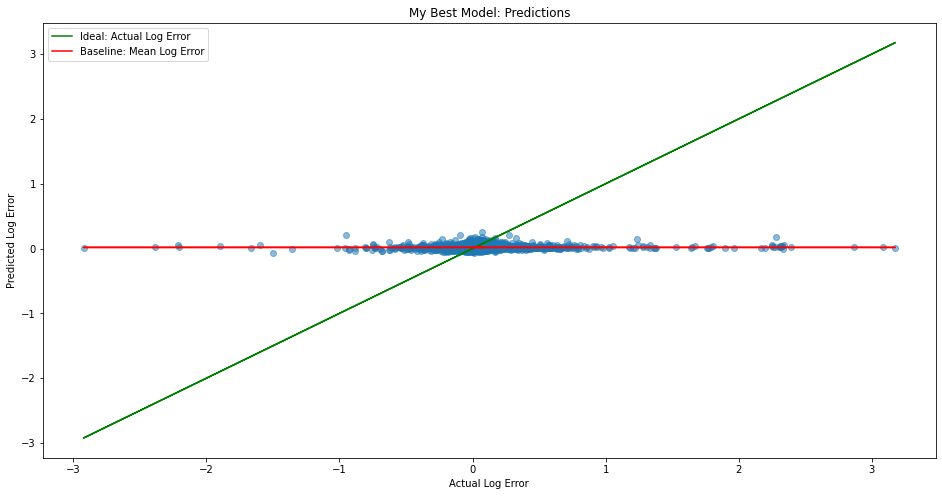

In [37]:
model.plot_predictions(y_test)

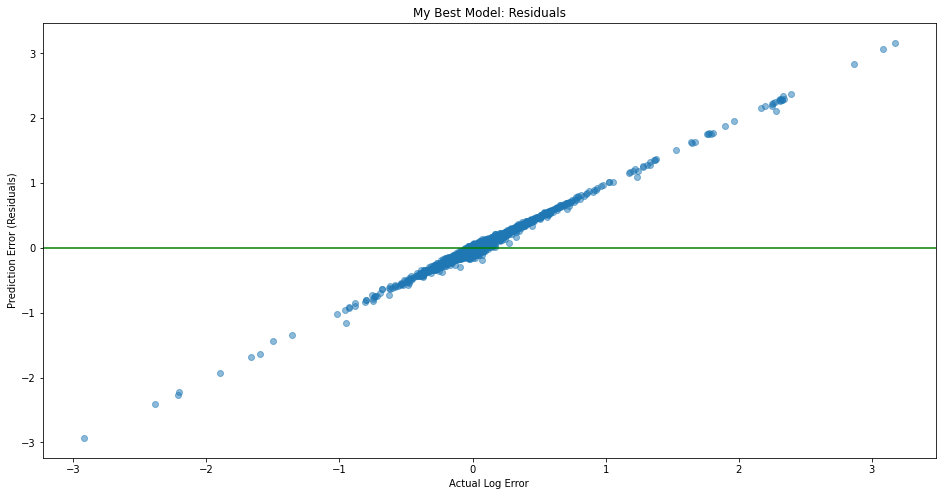

In [38]:
model.plot_residuals(y_test)

## What Are the Main Drivers of Log Error?

In [39]:
best_features = pd.DataFrame(best_model.feature_importances_, X_train.columns)
best_features.sort_values(by = 0, ascending = False).head()

,0
structure_dollar_per_sqft,0.145924
home_square_feet,0.139742
latitude,0.129873
longitude,0.121441
tax_rate,0.098024


Based on the natural selection of my Random Forest model, the main drivers of churn are:
* Structure Value per Square Foot
* Property Size
* Property Location

***
## Conclusion

* According to the important features property of my best model, the top drivers of logerror are structure value per square foot, size, and location.
* Unfortunately, since my model did not perform much better than baseline, I recommend further exploration using the features listed above as a starting point for clustering.

## With More Time...

* There's a lot of room for improvement here, so I'd like to spend more time exploring different cluster groups, running models with fewer features, and modeling cluster groups individually.